## IMPORT REQUIRED LIBERARIES

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

sns.set()

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [5]:
# import the regressors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

# import metrics
from sklearn.metrics import mean_squared_error

In [6]:
import warnings
warnings.filterwarnings("ignore")

## LOAD DATASET

In [7]:
df = pd.read_csv('KEEP DATASET DIRECTORY')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


## ANALYZING DATA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


## RECTIFY TO PROPER DATATYPE

In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


## CHECK FOR DUPLICATES

In [10]:
df[df.duplicated()]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment


## FIXING OUTLIER

In [11]:
def find_outlier_rows(df, col, level='both'):
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
    
    lower_bound = df[col].quantile(0.25) - 1.5 * iqr
    upper_bound = df[col].quantile(0.75) + 1.5 * iqr

    if level == 'lower':
        return df[df[col] < lower_bound]
    elif level == 'upper':
        return df[df[col] > upper_bound]
    else:
        return df[(df[col] > upper_bound) | (df[col] < lower_bound)]
    
    
def count_outliers(df):
    df_numeric = df.select_dtypes(include=['int', 'float'])

    columns = df_numeric.columns

    outlier_cols = [col for col in columns if len(find_outlier_rows(df_numeric, col)) != 0]
    
    outliers_df = pd.DataFrame(columns=['outlier_counts', 'outlier_percent'])

    for col in outlier_cols:
        outlier_count = len(find_outlier_rows(df_numeric, col))
        all_entries = len(df[col])
        outlier_percent = round(outlier_count * 100 / all_entries, 2)

        outliers_df.loc[col] = [outlier_count, outlier_percent]

    return outliers_df

COUNT OUTLIERS OF THE COLUMNS

In [12]:
count_outliers(df).sort_values('outlier_counts', ascending=False)

,outlier_counts,outlier_percent
Unemployment,481.0,7.47
Holiday_Flag,450.0,6.99
Weekly_Sales,34.0,0.53
Temperature,3.0,0.05


As we can see the outliers are mostly from Unemployment and Holiday_Flag

In [13]:
find_outlier_rows(df, 'Unemployment')['Unemployment'].describe()

count    481.000000
mean      11.447480
std        3.891387
min        3.879000
25%       11.627000
50%       13.503000
75%       14.021000
max       14.313000
Name: Unemployment, dtype: float64

In [14]:
find_outlier_rows(df, 'Holiday_Flag')['Holiday_Flag'].describe()

count    450.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: Holiday_Flag, dtype: float64

As outliers of Unemployment are obtained to be real and Holiday_Flag are having less outliers, we left those to intact for further analysis

we consider employment instead of unemployment for simple understanding

In [15]:
df['Employment'] = 100 - df['Unemployment']
df.sample(3)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Employment
5195,37,2010-12-31,460331.70,1,52.88,2.943,210.182398,8.476,91.524
2670,19,2011-09-12,1713769.06,0,40.18,3.627,136.503067,7.866,92.134
572,5,2010-05-02,317173.10,0,39.70,2.572,211.653972,6.566,93.434


In [16]:
find_outlier_rows(df, 'Weekly_Sales')

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Employment
189,2,2010-12-24,3436007.68,0,49.97,2.886,211.064660,8.163,91.837
241,2,2011-12-23,3224369.80,0,46.66,3.112,218.999550,7.441,92.559
471,4,2010-11-26,2789469.45,1,48.08,2.752,126.669267,7.127,92.873
474,4,2010-12-17,2740057.14,0,46.57,2.884,126.879484,7.127,92.873
475,4,2010-12-24,3526713.39,0,43.21,2.887,126.983581,7.127,92.873
523,4,2011-11-25,3004702.33,1,47.96,3.225,129.836400,5.143,94.857
526,4,2011-12-16,2771397.17,0,36.44,3.149,129.898065,5.143,94.857
527,4,2011-12-23,3676388.98,0,35.92,3.103,129.984548,5.143,94.857
761,6,2010-12-24,2727575.18,0,55.07,2.886,212.916508,7.007,92.993
1329,10,2010-11-26,2939946.38,1,55.33,3.162,126.669267,9.003,90.997


Here we observe only in the month of 11 and 12 are having most outliers and only one outlier from month of 10

Thus to resolve outlier the proposed system 
demands to split the data in month, year and day wise

## SPLITTING COLUMNS

In [17]:
df['Year']= df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.head(3)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Employment,Year,Month,Day
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,91.894,2010,5,2
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,91.894,2010,12,2
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,91.894,2010,2,19


## ANALYSING FROM TABLE AND GRAPH

In [18]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Employment,Year,Month,Day
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,92.000849,2010.965035,6.475524,15.650350
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,1.875885,0.797019,3.321797,8.753908
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,85.687000,2010.000000,1.000000,1.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,91.378000,2010.000000,4.000000,8.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,92.126000,2011.000000,6.000000,16.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,93.109000,2012.000000,9.000000,23.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,96.121000,2012.000000,12.000000,31.000000


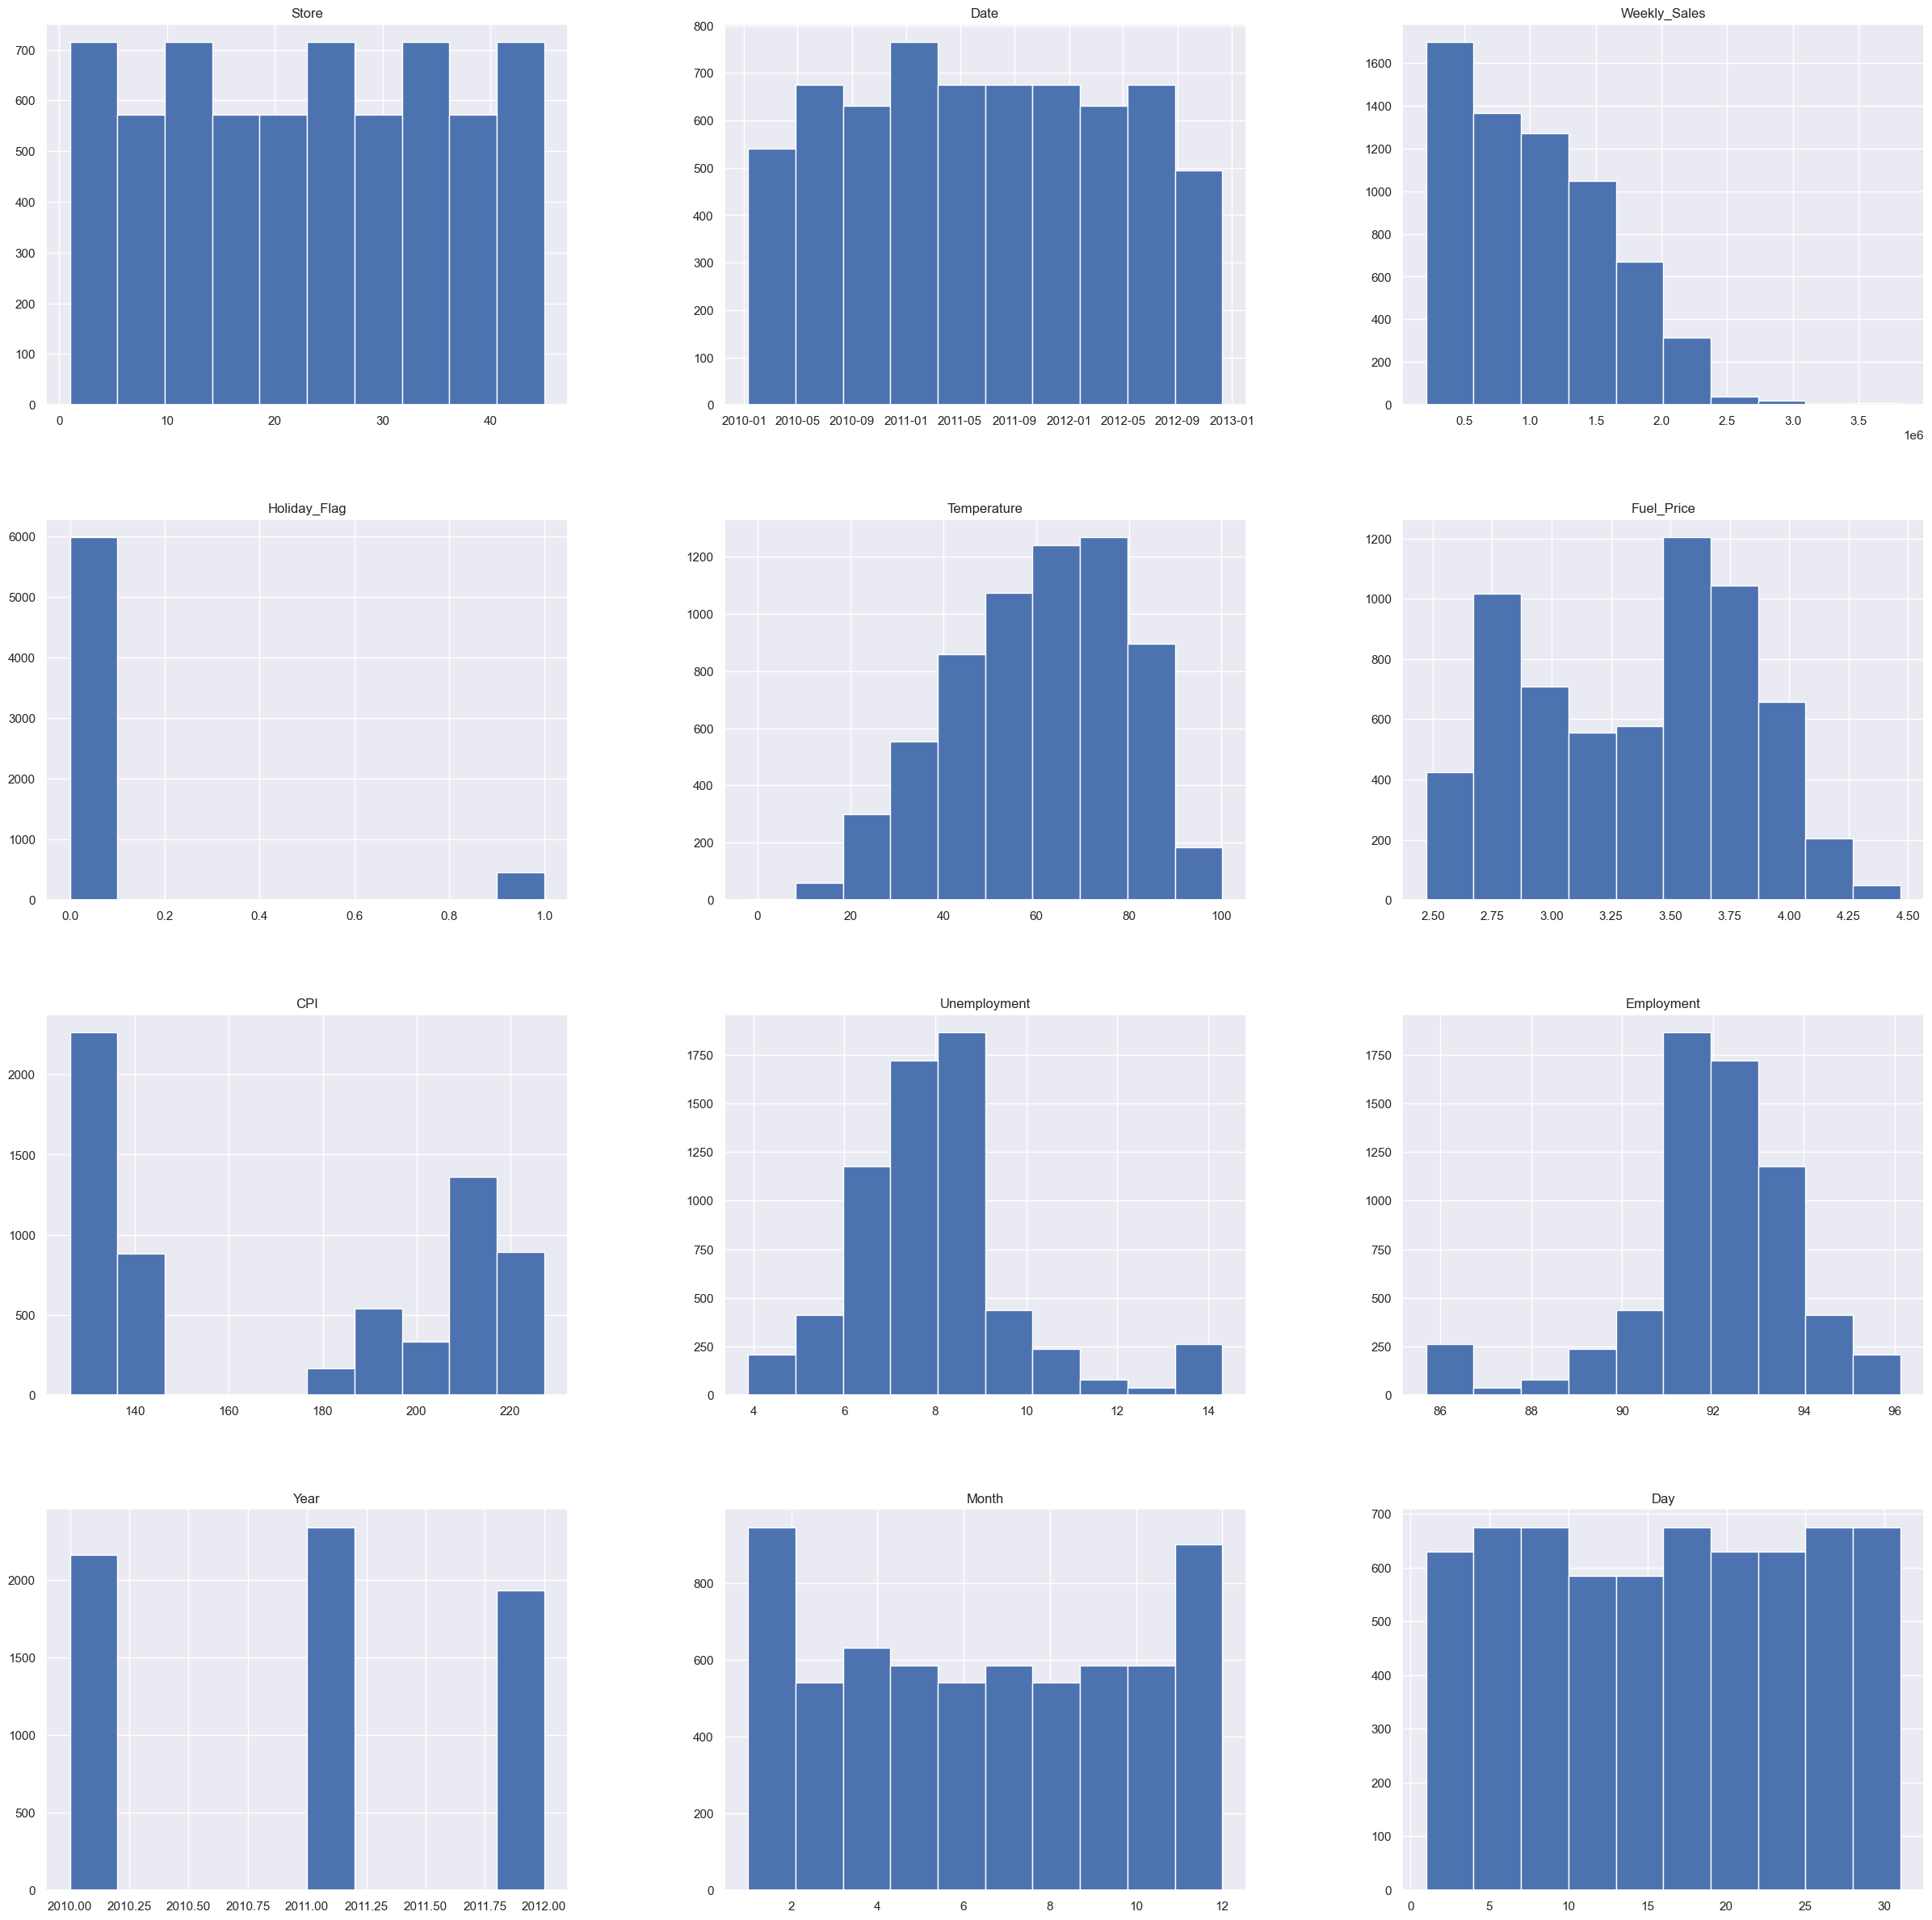

In [19]:
df.hist(figsize=(30,30))
plt.show()

From the above histograms, we can understand that:

 * The number of transactions occurred almost evenly across various stores and years.
 * The distribution of weekly_sales right-skewed. Only a few of the weekly sales are above 2 million USD.
 * The distribution of temperature is approximately normal.
 * The distribution of fuel_price is bi-modal.
 * CPI formed two clusters.
 * Unemployment rate is near normally distributed.
 * Four consecutive months November-February recorded the highest sales.

## OVERALL TREND OF SALES 

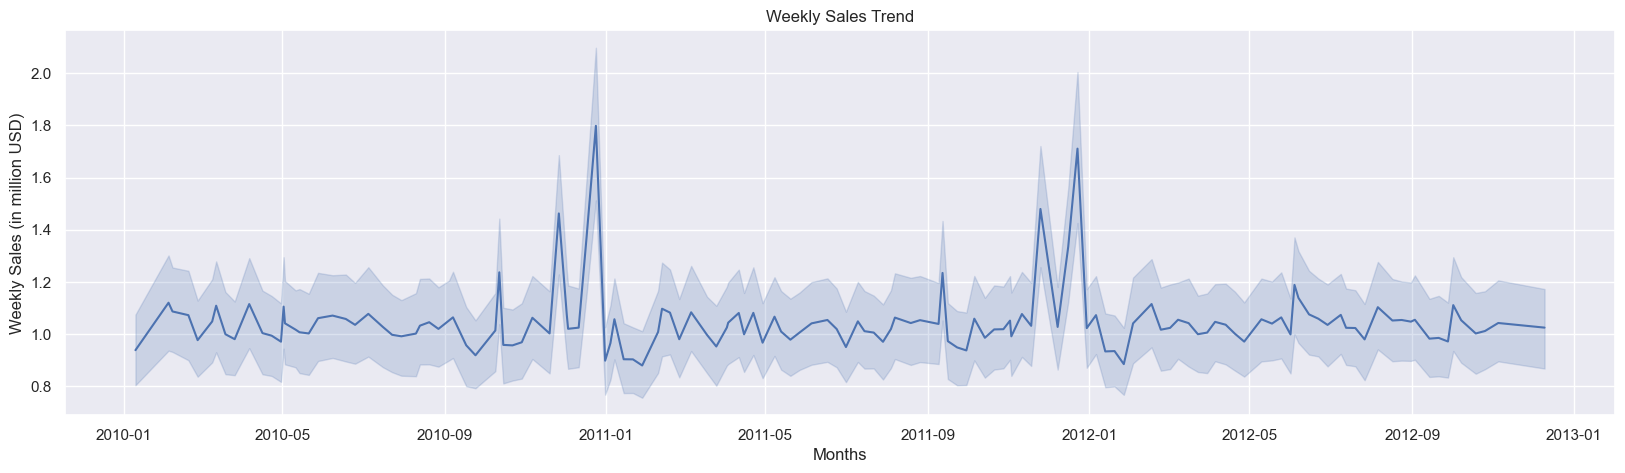

In [20]:
plt.figure(figsize=(20,5))

sns.lineplot(x=df.Date, y=(df.Weekly_Sales/1e6))

plt.xlabel('Months')
plt.ylabel('Weekly Sales (in million USD)')
plt.title('Weekly Sales Trend')


plt.show()

## SEASONLITY TRENDS

In [21]:
pivot_table = df.pivot_table(index='Month', columns='Year', values='Weekly_Sales')
pivot_table

Year,2010,2011,2012
Month,,,
1,9.386639e+05,9.420697e+05,9.567817e+05
2,1.064372e+06,1.042273e+06,1.057997e+06
3,1.034590e+06,1.011263e+06,1.025510e+06
4,1.021177e+06,1.033220e+06,1.014127e+06
5,1.039303e+06,1.015565e+06,1.053948e+06
6,1.055082e+06,1.038471e+06,1.082920e+06
7,1.023702e+06,9.976049e+05,1.025480e+06
8,1.025212e+06,1.044895e+06,1.064514e+06
9,9.983559e+05,1.026810e+06,9.988663e+05


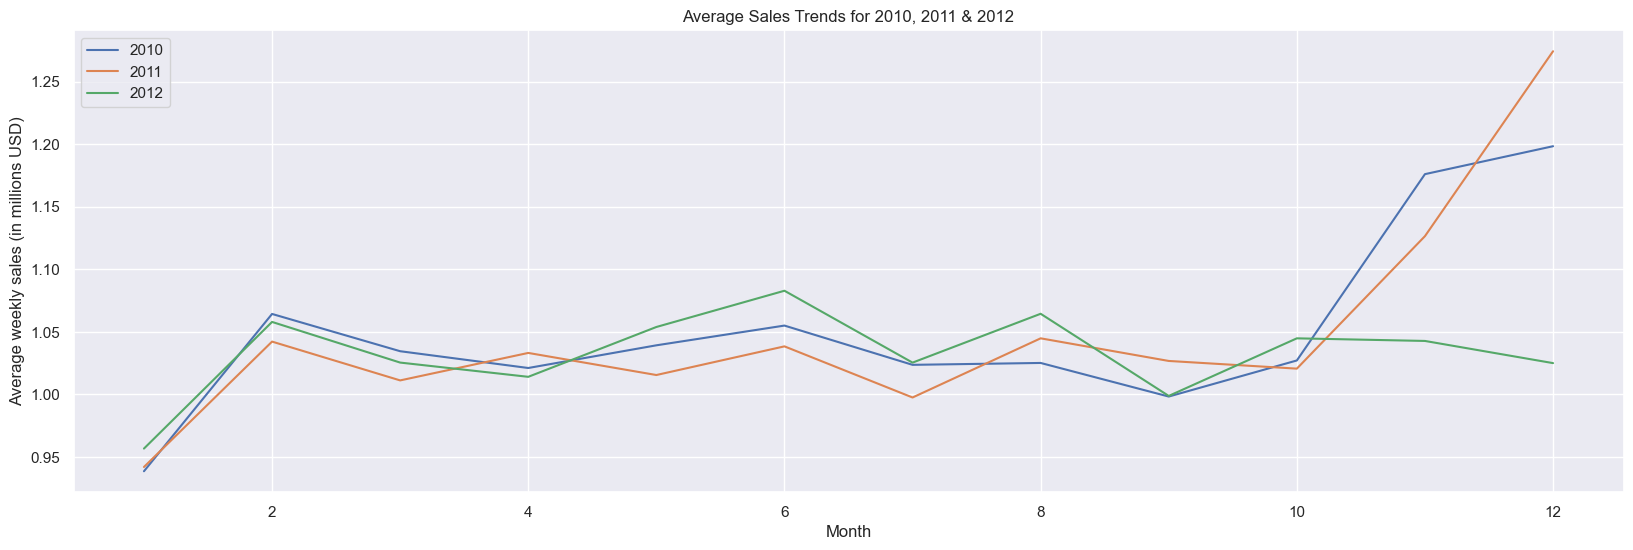

In [22]:
fig, ax = plt.subplots(figsize=(20, 6))

sns.lineplot(x=pivot_table.index, y=pivot_table[2010]/1e6, ax=ax, label='2010')
sns.lineplot( x=pivot_table.index, y=pivot_table[2011]/1e6, ax=ax, label='2011')
sns.lineplot( x=pivot_table.index, y=pivot_table[2012]/1e6, ax=ax, label='2012')

plt.ylabel('Average weekly sales (in millions USD)')
plt.title('Average Sales Trends for 2010, 2011 & 2012')

plt.legend()
plt.show()

## STORES HAD HIGHEST AND LOWEST AVG REVENUE OVER YEARS

In [23]:
sales_store = df.groupby('Store').sum().reset_index()

#TOP SALES & BOTTOM SALES
top_sales_store = sales_store.sort_values('Weekly_Sales',ascending=False).head()[['Store','Weekly_Sales']]
top_sales_store

,Store,Weekly_Sales
19,20,3.013978e+08
3,4,2.995440e+08
13,14,2.889999e+08
12,13,2.865177e+08
1,2,2.753824e+08


In [24]:
bottom_sales_store = sales_store.sort_values('Weekly_Sales',ascending=True).head()[['Store','Weekly_Sales']]
bottom_sales_store

,Store,Weekly_Sales
32,33,37160221.96
43,44,43293087.84
4,5,45475688.90
35,36,53412214.97
37,38,55159626.42


<AxesSubplot:xlabel='Store', ylabel='Weekly_Sales'>

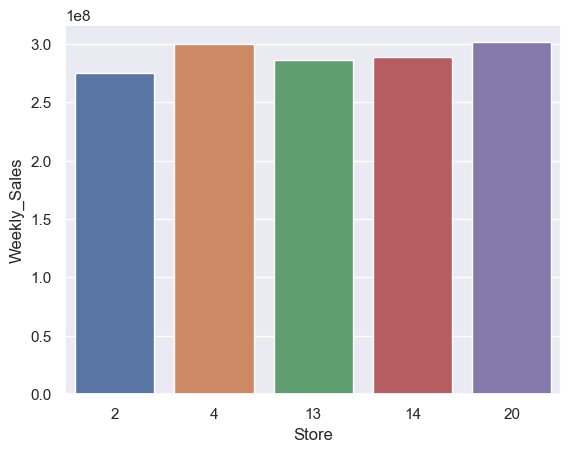

In [25]:
sns.barplot(x='Store',y='Weekly_Sales',data=top_sales_store)

<AxesSubplot:xlabel='Store', ylabel='Weekly_Sales'>

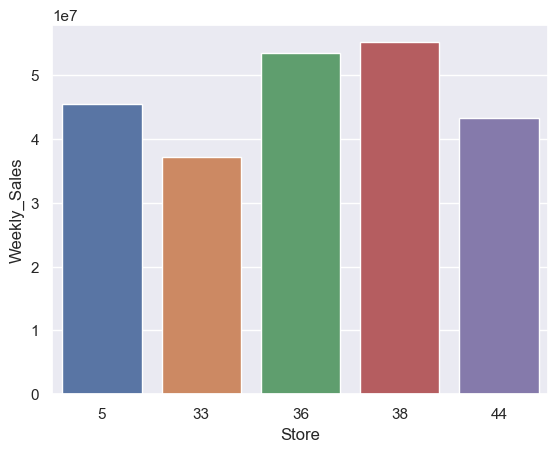

In [26]:
sns.barplot(x='Store',y='Weekly_Sales',data=bottom_sales_store)

## HOLIDAYS SALES VS NON HOLIDAYS SALES

In [27]:
non_holiday_sales = df[df['Holiday_Flag'] == 0]
holiday_sales = df[df['Holiday_Flag'] == 1]

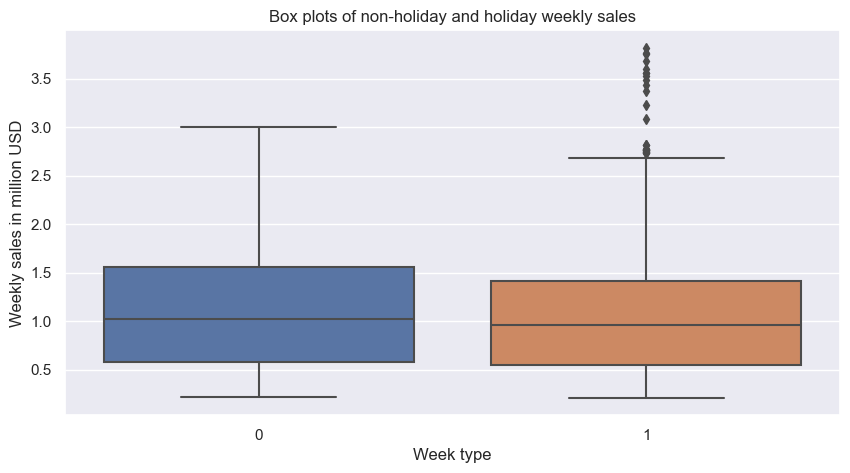

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=[holiday_sales['Weekly_Sales']/1e6, non_holiday_sales['Weekly_Sales']/1e6])
plt.ylabel('Weekly sales in million USD')
plt.xlabel('Week type')
plt.title('Box plots of non-holiday and holiday weekly sales')
plt.show()

## MODEL  BUILDING

In [29]:
df_copy = df.copy()

## DROP UNECESSARY COLUMNS

In [30]:
df_copy.drop(['Date', 'Unemployment'], axis=1, inplace=True)
df_copy.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Employment,Year,Month,Day
0,1,1643690.90,0,42.31,2.572,211.096358,91.894,2010,5,2
1,1,1641957.44,1,38.51,2.548,211.242170,91.894,2010,12,2
2,1,1611968.17,0,39.93,2.514,211.289143,91.894,2010,2,19
3,1,1409727.59,0,46.63,2.561,211.319643,91.894,2010,2,26
4,1,1554806.68,0,46.50,2.625,211.350143,91.894,2010,5,3


In [31]:
#separting X & Y
X = df_copy.drop('Weekly_Sales', axis=1)
y = df_copy['Weekly_Sales']

In [32]:
#scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
# Train & Test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=50)

## TRAINING THE MODEL

In [34]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [35]:
def evaluate_regressors_rmses(regressors, regressor_names, X_train, y_train, X_test, y_test):
    rmses = [evaluate_model(regressor, X_train, y_train, X_test, y_test) for regressor in regressors]
    regressor_rmses = dict(zip(regressor_names, rmses))
    df = pd.DataFrame.from_dict(regressor_rmses, orient='index')
    df = df.reset_index()
    df.columns = ['regressor_name', 'rmse']
    return df.sort_values('rmse', ignore_index=True)

In [36]:
linear_regressor = LinearRegression()
polynomial_features = PolynomialFeatures(degree=2)
polynomial_regressor = Pipeline([("polynomial_features", polynomial_features),
("linear_regression", linear_regressor)])
ridge_regressor = Ridge()
lasso_regressor = Lasso()
elastic_net_regressor = ElasticNet()
decision_tree_regressor = DecisionTreeRegressor()
random_forest_regressor = RandomForestRegressor()
boosted_tree_regressor = GradientBoostingRegressor()
neural_network_regressor = MLPRegressor()
support_vector_regressor = SVR()
grad_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, loss='ls')
knn_regressor = KNeighborsRegressor(n_neighbors=5, weights='uniform')
spline_regressor = make_pipeline(PolynomialFeatures(3), LinearRegression())

In [37]:
# collect the list of regressors
regressors = [linear_regressor, polynomial_regressor, ridge_regressor, lasso_regressor, elastic_net_regressor, 
              decision_tree_regressor, random_forest_regressor, boosted_tree_regressor, neural_network_regressor, 
              support_vector_regressor, knn_regressor, spline_regressor]

# collect the names of regressors
regressor_names = ["Linear Regression", "Polynomial Regression", "Ridge Regression", "Lasso Regression", 
                   "Elastic Net Regression", "Decision Tree Regression", "Random Forest Regression", 
                   "Boosted Tree Regression", "Neural Network Regression", "Support Vector Regression", 
                   "K-Nearest Neighbour Regression", "Spline Regression"]

In [38]:
print('\033[1m Table of regressors and their RMSEs')
evaluate_regressors_rmses(regressors, regressor_names, X_train, y_train, X_test, y_test)

 Table of regressors and their RMSEs


,regressor_name,rmse
0,Random Forest Regression,1.159964e+05
1,Decision Tree Regression,1.480225e+05
2,Boosted Tree Regression,1.750082e+05
3,Spline Regression,4.377734e+05
4,K-Nearest Neighbour Regression,4.606521e+05
5,Polynomial Regression,4.786470e+05
6,Ridge Regression,5.209623e+05
7,Lasso Regression,5.209627e+05
8,Linear Regression,5.209628e+05
9,Elastic Net Regression,5.258987e+05


In [39]:
rmse = evaluate_regressors_rmses(regressors, regressor_names, X_train, y_train, X_test, y_test)

best_rmse = rmse.iloc[0]['rmse']
median_sale = df['Weekly_Sales'].median()
percent_deviation = round((best_rmse*100/median_sale), 2)

# print the result
print('The model has average percentage error of {}%'.format(percent_deviation))

The model has average percentage error of 12.05%


### The best model for predicting future sales is the Random Forest Regressor model,which achieved an RMSE of 1.17e+05. This is a good estimate as it is 88% close to the median sale of the data.

###  sales during holiday weeks are significantly higher than during non-holiday weeks